# Rossmann Stores Analysis

In [67]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import operator

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error

## Variables

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Load datasets
store = pd.read_csv('data/raw/store.csv')
train = pd.read_csv('data/raw/train.csv', low_memory=False)
test = pd.read_csv('data/raw/test.csv')

## Exploration

### Store data

In [3]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [4]:
store.shape

(1115, 10)

In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [6]:
# Proportion of NaN among the features
store.isna().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [7]:
store.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

This dataset contains $1115$ rows, one for each store. Therefore, the `Store` colums is a primary key of this table.

In [8]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


### Sales data

In [9]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [10]:
train.shape

(1017209, 9)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
train.isna().sum() / train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

In [13]:
train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [14]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,2013-05-01,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [15]:
test.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [16]:
test.shape

(41088, 8)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [18]:
test.isna().sum() / test.shape[0]

Id               0.000000
Store            0.000000
DayOfWeek        0.000000
Date             0.000000
Open             0.000268
Promo            0.000000
StateHoliday     0.000000
SchoolHoliday    0.000000
dtype: float64

In [19]:
test.nunique()

Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64

In [20]:
test.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088,41077.000000,41088.000000,41088,41088.000000
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-14,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.500000,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000
25%,10272.750000,279.750000,2.000000,NaN,1.000000,0.000000,NaN,0.000000
50%,20544.500000,553.500000,4.000000,NaN,1.000000,0.000000,NaN,0.000000
75%,30816.250000,832.250000,6.000000,NaN,1.000000,1.000000,NaN,1.000000


## Analysis

#### Open

In [21]:
# assume store open, if not provided
train['Open'].fillna(1, inplace=True)

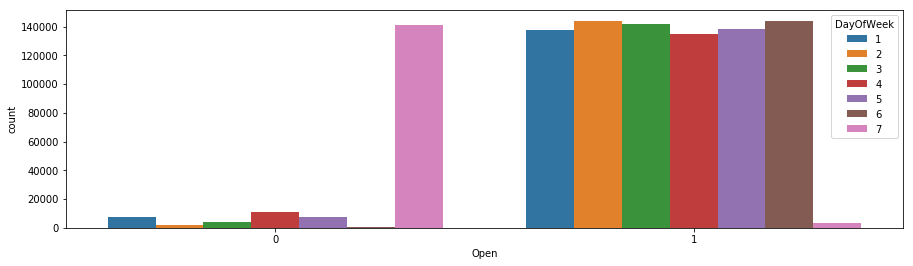

In [22]:
# Open
fig, axis = plt.subplots(1, 1, figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek', data=train, ax=axis)

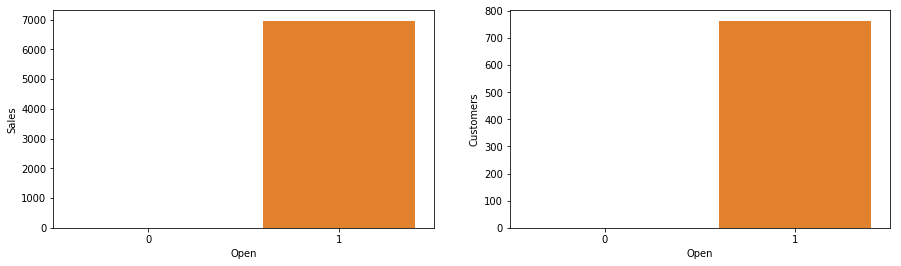

In [23]:
# Plot average sales & customers for Open
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='Open', y='Sales', data=train, ax=axis1)
sns.barplot(x='Open', y='Customers', data=train, ax=axis2)

When a shop is not open, the sales amount is $0$. Therefore we can set the sales amount to $0$ evey time a shop is not open and then drop the `Open` column.

#### Date

In [24]:
# Assign Date column to Date (Year-Month) instead of (Year-Month-Day)
train['YearMonth'] = train['Date'].apply(lambda x: (str(x)[:7]))
# convert date to datetime
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

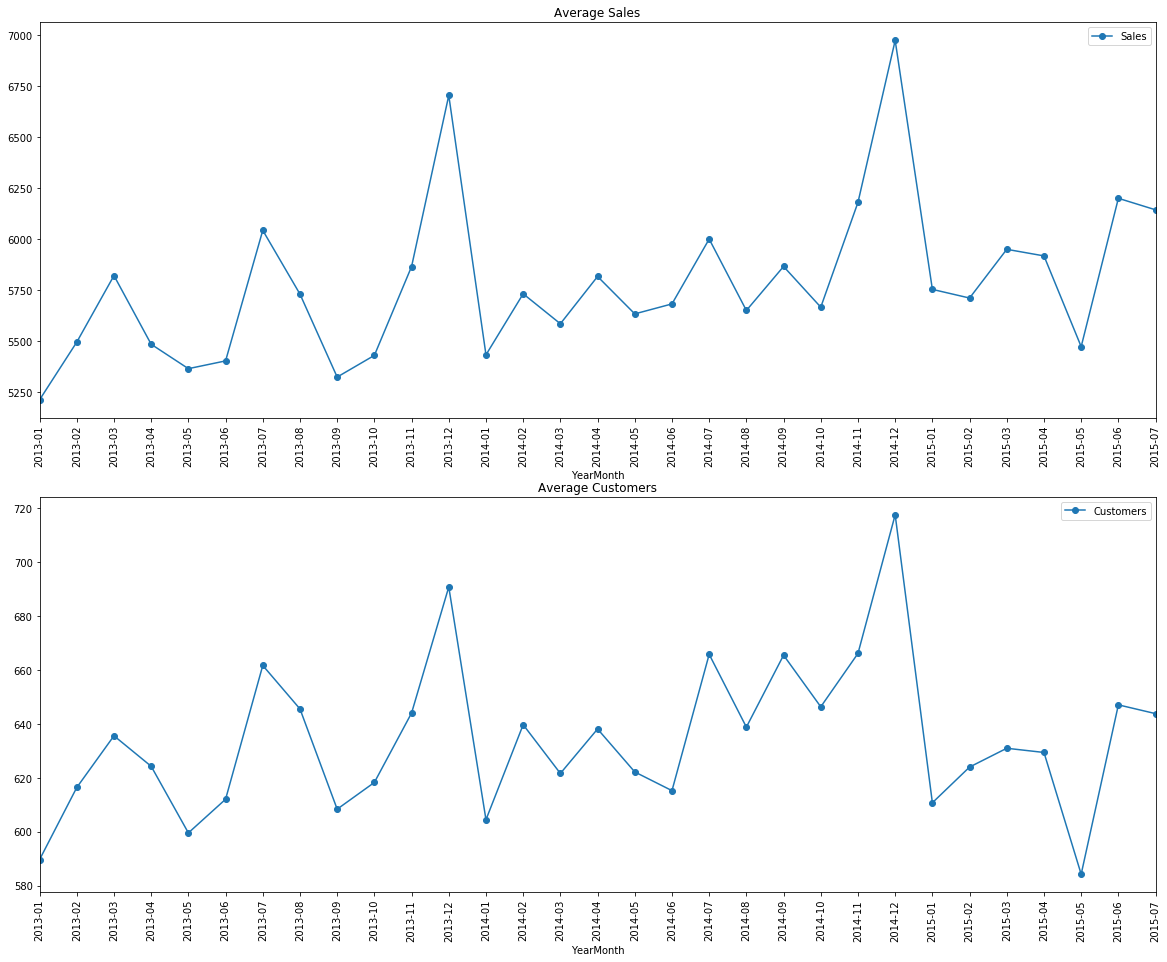

In [25]:
# group by (Year-Month) and get average sales and customers
average_sales = train.groupby('YearMonth')["Sales"].mean()
average_customers = train.groupby('YearMonth')["Customers"].mean()

# plot average sales and customers over time (Year-Month)
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 16))

ax = average_sales.plot(legend=True, ax=axis1, marker='o', title="Average Sales")
ax.set_xticks(range(len(average_sales)))
xlabels = ax.set_xticklabels(average_sales.index.tolist(), rotation=90)

ax = average_customers.plot(legend=True, ax=axis2, marker='o', title="Average Customers")
ax.set_xticks(range(len(average_customers)))
xlabels = ax.set_xticklabels(average_customers.index.tolist(), rotation=90)

Very correlated.

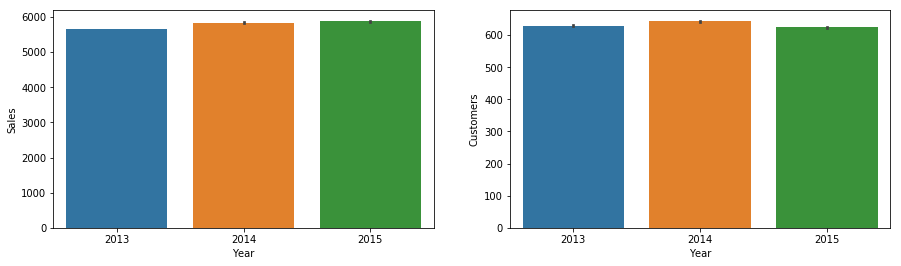

In [26]:
# Plot average sales & customers for every year
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

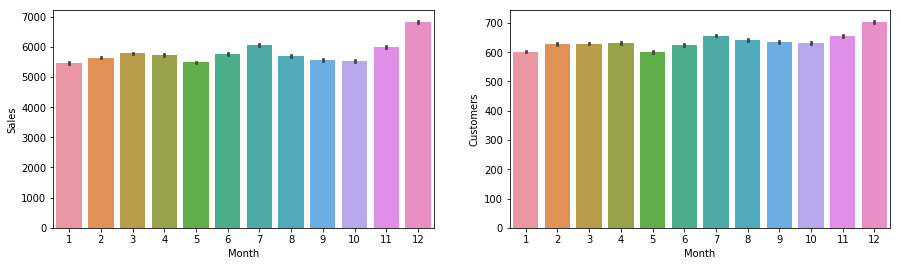

In [27]:
# Plot average sales & customers for every month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='Month', y='Sales', data=train, ax=axis1)
sns.barplot(x='Month', y='Customers', data=train, ax=axis2)

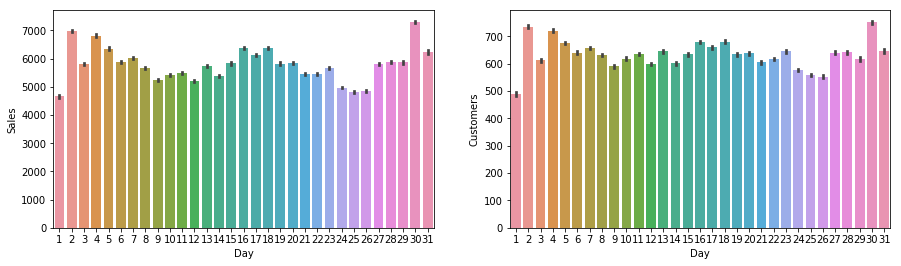

In [28]:
# Plot average sales & customers for every day
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='Day', y='Sales', data=train, ax=axis1)
sns.barplot(x='Day', y='Customers', data=train, ax=axis2)

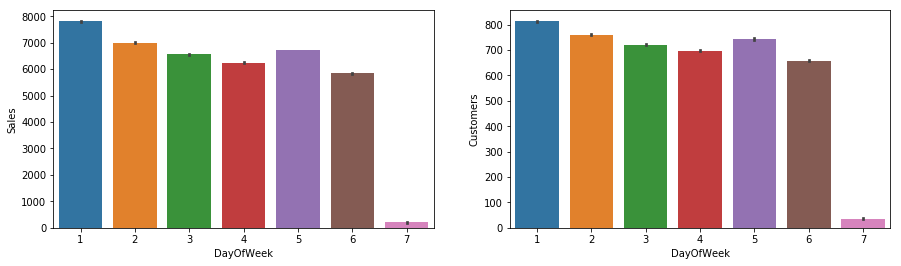

In [29]:
# Plot average sales & customers for every DayOfWeek
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='DayOfWeek', y='Sales', data=train, ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, ax=axis2)

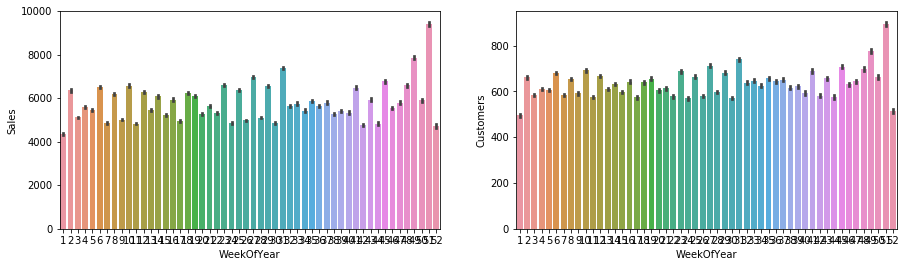

In [30]:
# Plot average sales & customers for every month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='WeekOfYear', y='Sales', data=train, ax=axis1)
sns.barplot(x='WeekOfYear', y='Customers', data=train, ax=axis2)

#### Promo

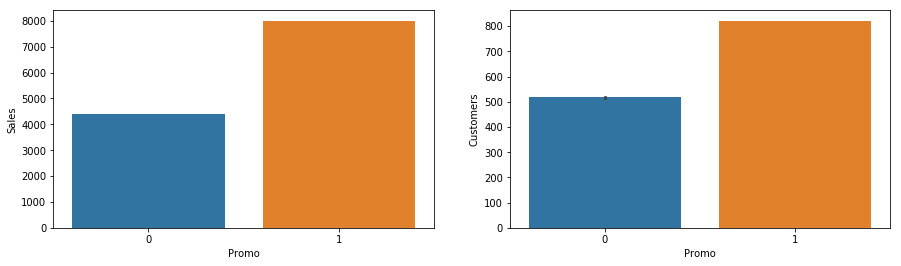

In [31]:
# Plot average sales & customers with/without promo
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)

#### StateHoliday

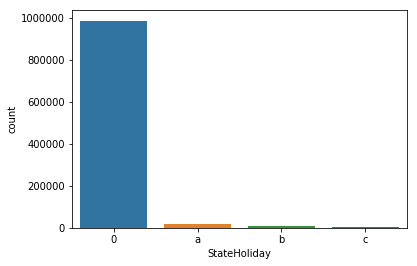

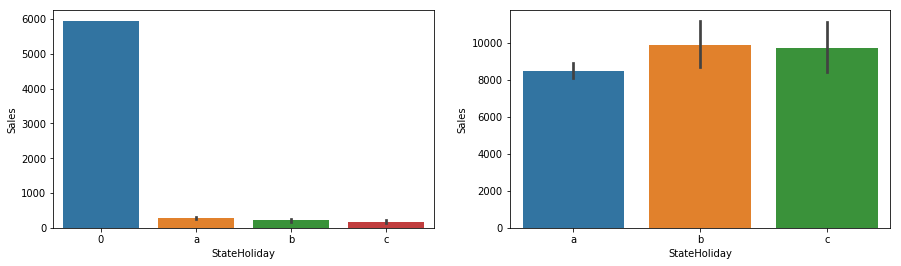

In [32]:
# StateHoliday column has values 0 & "0", So, we need to merge values with 0 to "0"
train.loc[train["StateHoliday"] == 0, "StateHoliday"] = "0"
# Plot
sns.countplot(x='StateHoliday', data=train)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
mask = (train["StateHoliday"] != "0") & (train["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train[mask], ax=axis2)

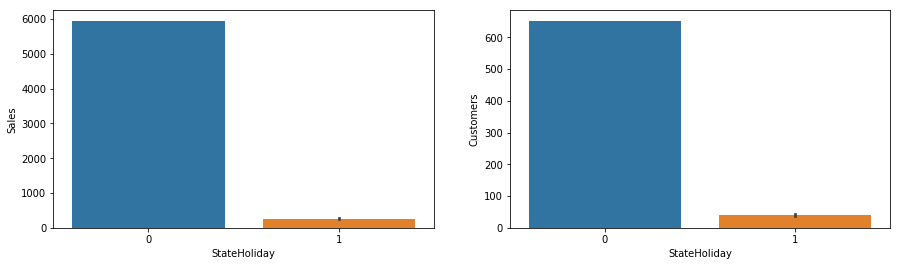

In [33]:
train["StateHoliday"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=train, ax=axis2)

#### SchoolHoliday

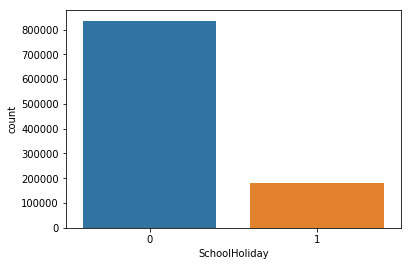

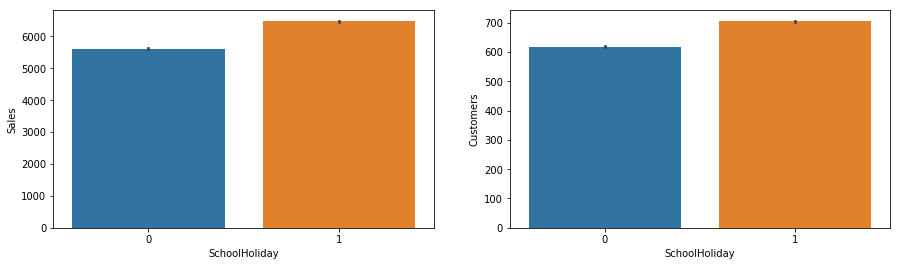

In [34]:
# Plot
sns.countplot(x='SchoolHoliday', data=train)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train, ax=axis2)

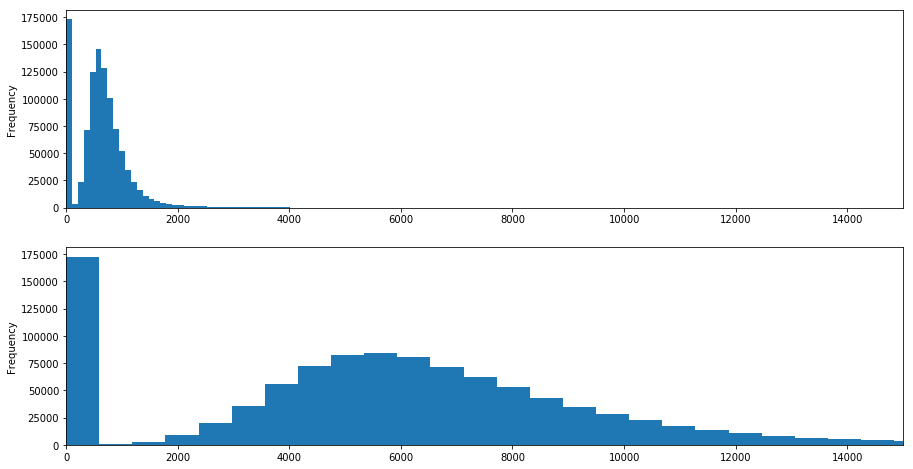

In [35]:
# Plot sales and customers values  
# Notice that values with 0 is mostly because the store was closed
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(15, 8))
train["Customers"].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis1)
train["Sales"].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis2)

#### Store

In [36]:
# Merge store with average store sales & customers
average_sales_customers = train.groupby('Store')[["Sales", "Customers"]].mean()
sales_customers_df = pd.DataFrame(data = {'Store': average_sales_customers.index,
                                          'Sales': average_sales_customers["Sales"].values, 
                                          'Customers': average_sales_customers["Customers"].values}, 
                                  columns=['Store', 'Sales', 'Customers'])
store_df = pd.merge(sales_customers_df, store, on='Store')
store_df.head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


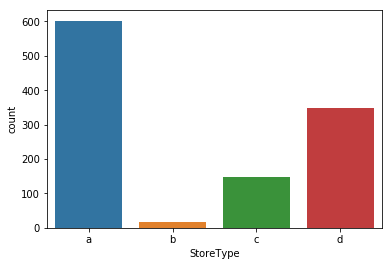

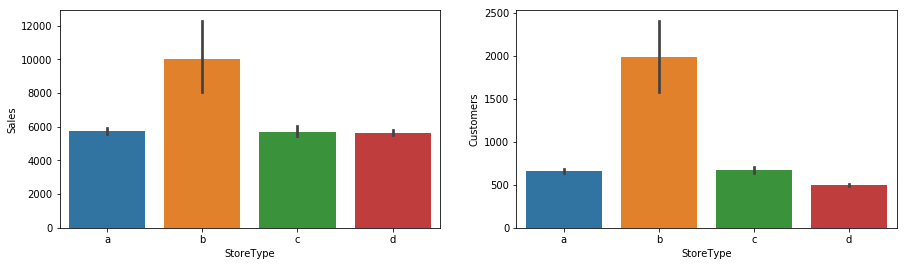

In [37]:
# Plot StoreType, & StoreType vs average sales and customers
sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'])
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='StoreType', y='Sales', data=store_df, order=['a','b','c', 'd'], ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=store_df, order=['a','b','c', 'd'], ax=axis2)

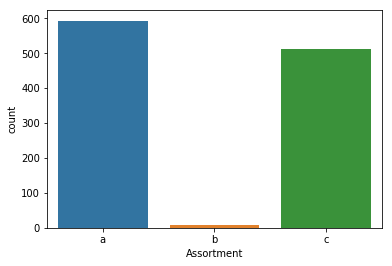

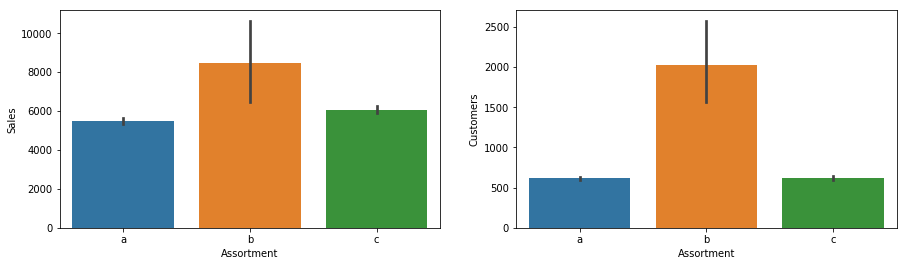

In [38]:
# Plot Assortment, & Assortment vs average sales and customers
sns.countplot(x='Assortment', data=store_df, order=['a','b','c'])
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Assortment', y='Sales', data=store_df, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=store_df, order=['a','b','c'], ax=axis2)

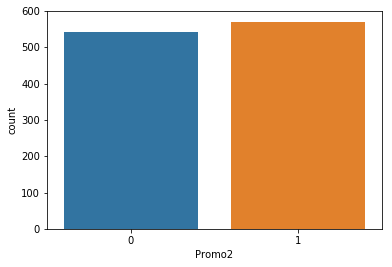

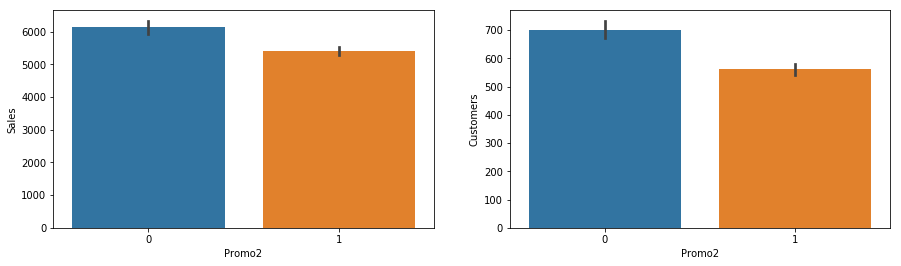

In [39]:
# Plot Promo2, & Promo2 vs average sales and customers
sns.countplot(x='Promo2', data=store_df)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Promo2', y='Sales', data=store_df, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=store_df, ax=axis2)

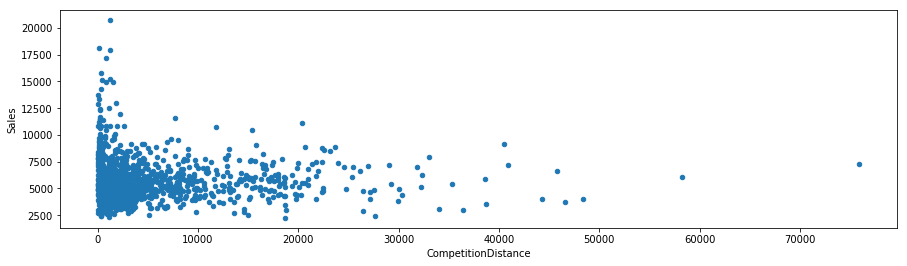

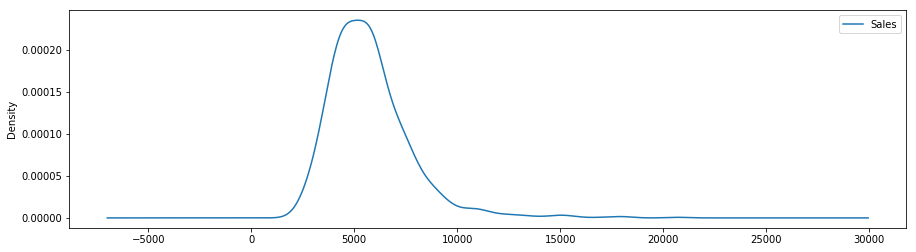

In [40]:
# fill NaN values
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median(), inplace=True)
# Plot CompetitionDistance Vs Sales
store_df.plot(kind='scatter', x='CompetitionDistance', y='Sales', figsize=(15, 4))
store_df.plot(kind='kde', x='CompetitionDistance', y='Sales', figsize=(15, 4))

In [41]:
store_df[(store_df["CompetitionOpenSinceYear"]==2014) & (store_df["CompetitionOpenSinceMonth"]==2)]

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
29,30,4367.352442,641.006369,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
44,45,4422.991507,343.505308,d,a,9710.0,2.0,2014.0,0,NaN,NaN,NaN
267,268,4062.462845,497.722930,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN


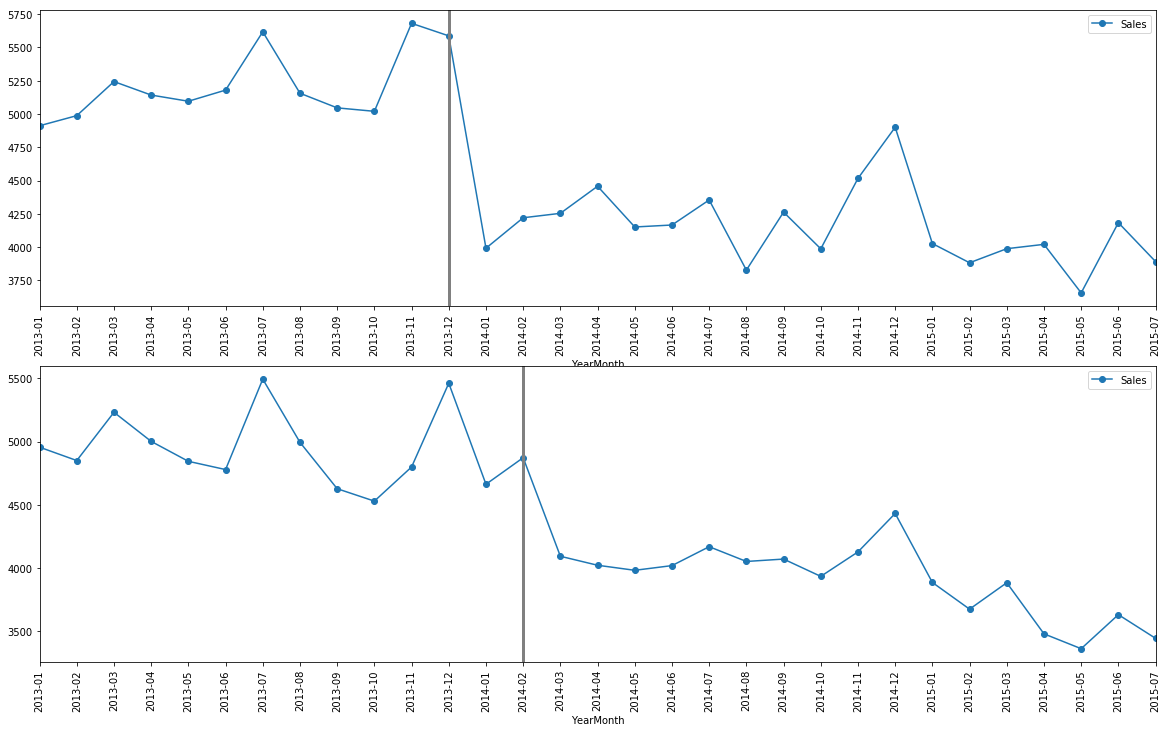

In [48]:
# What happened to the average sales of a store over time when competition started?
# Example: the average sales for store_id = 6 has dramatically decreased since the competition started

store_ids = [6, 30]
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 12))
axs = [axis1, axis2]
for (i, store_id) in enumerate(store_ids):
    store_data = train[train["Store"] == store_id]

    average_store_sales = store_data.groupby('YearMonth')["Sales"].mean()

    # Get year, and month when Competition started
    y = store_df["CompetitionOpenSinceYear"].loc[store_df["Store"]  == store_id].values[0]
    m = store_df["CompetitionOpenSinceMonth"].loc[store_df["Store"] == store_id].values[0]
    # Plot 
    ax = average_store_sales.plot(legend=True, marker='o', ax=axs[i])
    axs[i].set_xticks(range(len(average_store_sales)))
    axs[i].set_xticklabels(average_store_sales.index.tolist(), rotation=90)

    # Since all data of store sales given in rossmann_df starts with year=2013 till 2015,
    # So, we need to check if year>=2013 and y & m aren't NaN values.
    if y >= 2013 and y == y and m == m:
        axs[i].axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')

In [50]:
data_merged = train.merge(store, left_on='Store', right_on='Store', how='left')
data_merged.fillna(0, inplace=True)
data_merged.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,YearMonth,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015-07,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


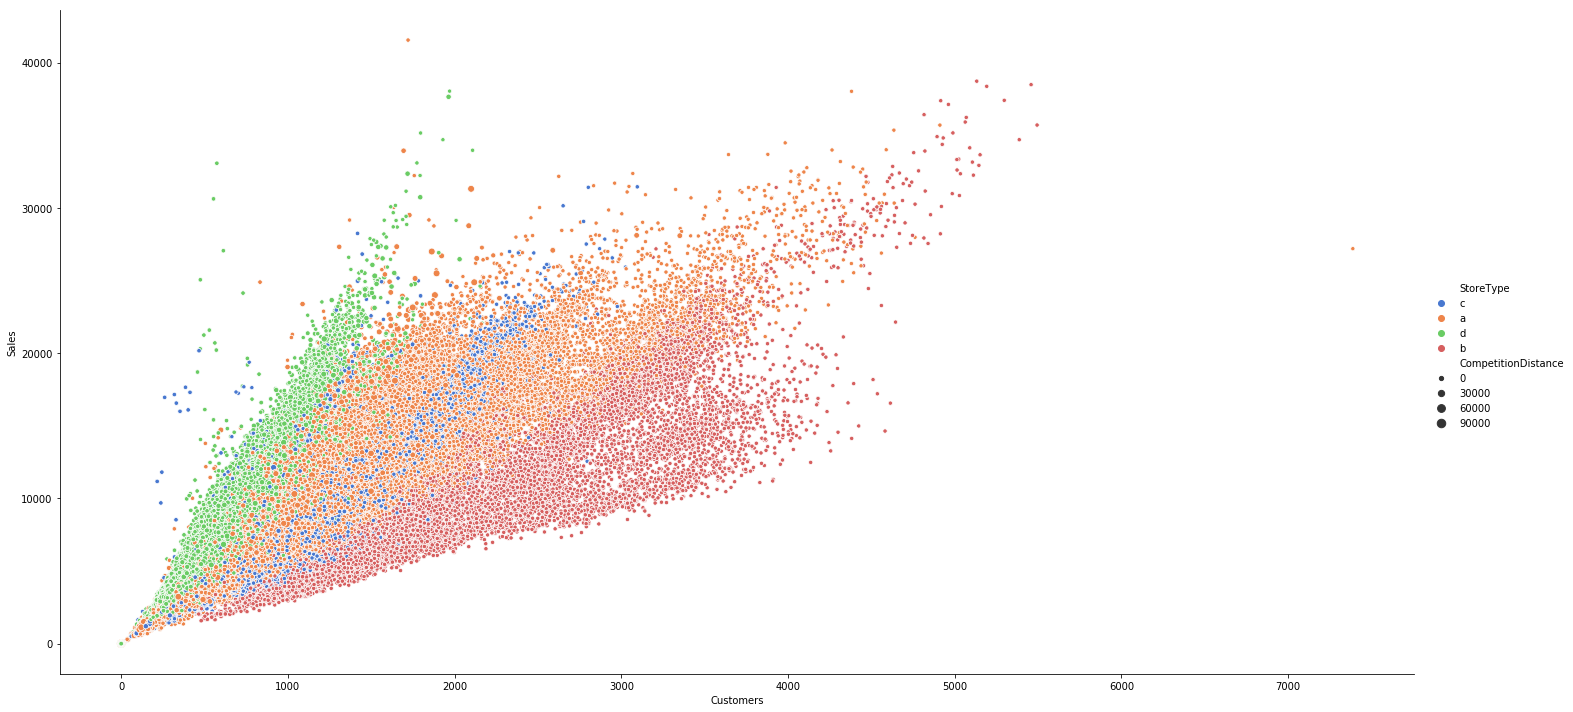

In [51]:
# Plot influence of the store type and number of customers
sns.relplot(x='Customers', y='Sales', hue='StoreType', size='CompetitionDistance',
            palette='muted', height=10, aspect=2,
            data=data_merged)

In [52]:
# Indicate that sales on that day are in promo interval
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
         7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
data_merged['monthStr'] = data_merged.Month.map(month2str)
data_merged.loc[data_merged.PromoInterval == 0, 'PromoInterval'] = ''
data_merged['IsPromoMonth'] = 0
for interval in data_merged.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            data_merged.loc[(data_merged.monthStr == month) & 
                            (data_merged.PromoInterval == interval), 'IsPromoMonth'] = 1

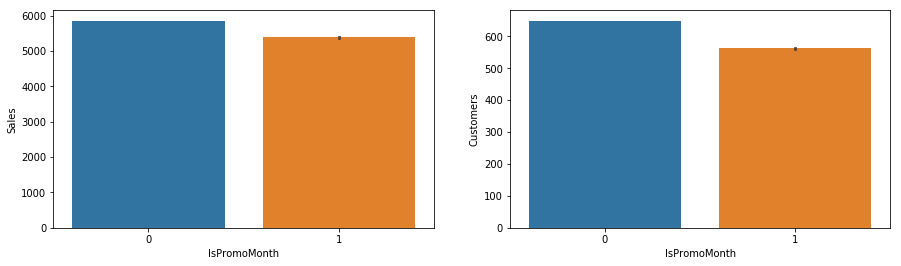

In [53]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='IsPromoMonth', y='Sales', data=data_merged, ax=axis1)
sns.barplot(x='IsPromoMonth', y='Customers', data=data_merged, ax=axis2)

## Model

In [54]:
def merge_data(data_sales, data_store, remove_outliers=False):
    data_merged = data_sales.merge(data_store, left_on='Store', right_on='Store', how='left')
    if remove_outliers:
        # One store with a huge number of customers
        data_merged = data_merged[data_merged['Customers'] <= 6000]
        # Two stores with competition before 1980
        data_merged = data_merged[(data_merged['CompetitionOpenSinceYear'] >= 1980) | (data_merged['CompetitionOpenSinceYear'] == 0.)]
        # Two stores with competition distance >= 5000
        data_merged = data_merged[data_merged['CompetitionDistance'] <= 5000]
    return data_merged

def preprocessing(data_sales, data_store, remove_outliers=False):
    # features
    features = []
    # convert date to datetime
    data_sales['Date'] = pd.to_datetime(data_sales['Date'], format='%Y-%m-%d')
    # assume store open, if not provided
    data_sales.fillna(1, inplace=True)
    # consider only open stores for training. Closed stores wont count into the score
    data_sales = data_sales[data_sales["Open"] != 0]
    # merge sales and store
    data = merge_data(data_sales, data_store, remove_outliers=False)
    # remove NaNs
    data["CompetitionDistance"].fillna(data["CompetitionDistance"].median(), inplace=True)
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    data["StoreType"] = data["StoreType"].map({'a': 0, 'b': 3, 'c': 2, 'd': 1})
    data["Assortment"] = data["Assortment"].map({'a': 0, 'b': 2, 'c': 1})
    data["StateHoliday"] = data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    return data, features

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [57]:
## Start of main script
print("Load the training, test and store data using pandas")
store = pd.read_csv('data/raw/store.csv')
train = pd.read_csv('data/raw/train.csv', low_memory=False)
test = pd.read_csv('data/raw/test.csv')

Load the training, test and store data using pandas


In [58]:
# Use only Sales bigger then zero
train = train[train["Sales"] > 0]
# save ids of closed stores, because we will assign their sales value to 0 later(see below)
closed_store_ids = test.loc[test["Open"] == 1, "Id"].values

In [59]:
train, features = preprocessing(train, store)
test, _ = preprocessing(test, store)

In [61]:
print(features)
train.head(3)

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,2,...,0.0,,2015,7,31,31,82.0,0.00,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.50,Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,0,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,52.25,Jul,1


In [62]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 300

In [63]:
print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = X_train.Sales
y_valid = X_valid.Sales
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

Train a XGBoost model


/Users/emmademarecaux/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/emmademarecaux/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [86]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, verbose_eval=True)

[0]	train-rmse:5586.42	eval-rmse:5556.62
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4276.2	eval-rmse:4250.31
[2]	train-rmse:3357.08	eval-rmse:3349.35
[3]	train-rmse:2813.86	eval-rmse:2817.21
[4]	train-rmse:2474.35	eval-rmse:2484.13
[5]	train-rmse:2290.43	eval-rmse:2303.25
[6]	train-rmse:2093.82	eval-rmse:2107.16
[7]	train-rmse:1912	eval-rmse:1931.25
[8]	train-rmse:1845.62	eval-rmse:1868.97
[9]	train-rmse:1812.47	eval-rmse:1839.25
[10]	train-rmse:1770.29	eval-rmse:1801.93
[11]	train-rmse:1689.87	eval-rmse:1722.93
[12]	train-rmse:1653.1	eval-rmse:1686.35
[13]	train-rmse:1541.8	eval-rmse:1577.36
[14]	train-rmse:1526.99	eval-rmse:1562.39
[15]	train-rmse:1513.21	eval-rmse:1548.8
[16]	train-rmse:1491.1	eval-rmse:1529.28
[17]	train-rmse:1450.36	eval-rmse:1487.09
[18]	train-rmse:1358.95	eval-rmse:1396.54
[19]	train-rmse:1350.44	eval-rmse:1390.06
[20]	train-rmse:1317.92	eval-rmse:

[191]	train-rmse:586.164	eval-rmse:707.61
[192]	train-rmse:584.579	eval-rmse:707.166
[193]	train-rmse:584.014	eval-rmse:706.74
[194]	train-rmse:583.28	eval-rmse:706.267
[195]	train-rmse:582.345	eval-rmse:705.654
[196]	train-rmse:581.875	eval-rmse:705.444
[197]	train-rmse:581.124	eval-rmse:705.062
[198]	train-rmse:580.148	eval-rmse:704.331
[199]	train-rmse:579.653	eval-rmse:704.118
[200]	train-rmse:578.598	eval-rmse:703.556
[201]	train-rmse:577.589	eval-rmse:703.25
[202]	train-rmse:576.618	eval-rmse:703.107
[203]	train-rmse:575.365	eval-rmse:702.047
[204]	train-rmse:574.88	eval-rmse:701.49
[205]	train-rmse:574.178	eval-rmse:701.204
[206]	train-rmse:573.241	eval-rmse:700.82
[207]	train-rmse:572.286	eval-rmse:700.397
[208]	train-rmse:571.427	eval-rmse:699.099
[209]	train-rmse:570.751	eval-rmse:699.185
[210]	train-rmse:570.084	eval-rmse:698.723
[211]	train-rmse:569.3	eval-rmse:698.506
[212]	train-rmse:568.341	eval-rmse:697.8
[213]	train-rmse:567.874	eval-rmse:697.718
[214]	train-rmse:567.0

In [87]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = mean_squared_error(X_valid.Sales.values, yhat)
print('RMSE: {:.6f}'.format(error))

Validating
RMSE: 457837.785478


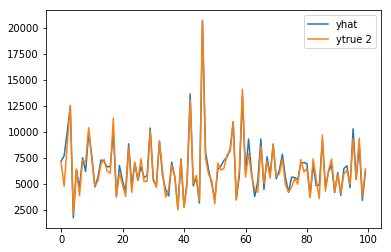

In [94]:
i = 100
x = range(len(yhat[:i]))
ytrue = X_valid.Sales.values
plt.plot(x, yhat[:i], label = "yhat")
plt.plot(x, ytrue[:i], label = "ytrue 2")
plt.legend()
plt.show()

In [95]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)

# append rows(store,date) that were closed, and assign their sales value to 0
result = pd.DataFrame({"Id": test["Id"], 'Sales': test_probs})
result = result.append(pd.DataFrame(data=zip(closed_store_ids, [0]*len(closed_store_ids)), columns=["Id", "Sales"]))
result.to_csv("test_sales.csv", index=False)

Make predictions on the test set


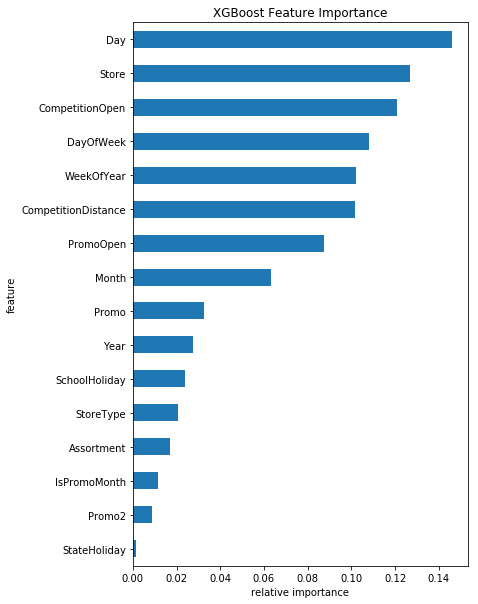

In [96]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)